# Analyis of EEG data 

Based on Chip Audette's analysis


In [12]:
import mne
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from mne import io, read_proj, read_selection
from mne.datasets import sample
from mne.time_frequency import psd_multitaper
from mne.minimum_norm import read_inverse_operator, compute_source_psd


mne.set_log_level('INFO')

In [13]:
# Authors: Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
from mne import io
from mne.minimum_norm import read_inverse_operator, source_band_induced_power

In [14]:
# from mne_openbci import read_raw_openbci #Convert OpenBCI data
# Alternatively you can use EEG Viewer GUI to convert to edf
fname = "/home/vagrant/notebooks/data/OpenBCI-RAW-2017-01-12_15-57-48.txt"
fnameEDF = "/home/vagrant/notebooks/data/OpenBCI-RAW-2015-12-17_23-17-26_signals_only.edf"

# 250 and 200 for Cylon and Ganglion
fs_Hz = 200.0

# data = np.loadtxt(fname, delimiter = ',', skiprows=5)
data = np.loadtxt(fname,
                  delimiter=',',
                  usecols=(0,1,2,3,4),
                  skiprows=6)

print(data)

[[  0.    11.91   9.54  12.76   7.36]
 [  1.    14.13  15.09  17.96  21.85]
 [  2.    15.69  20.44  12.67  20.51]
 ..., 
 [ 69.    21.16  17.3   15.59  14.57]
 [ 70.    15.88  13.13  16.26  15.49]
 [ 71.    17.13  12.22  14.2   10.51]]


In [15]:
# check the packet counter for dropped packets
data_indices = data[:, 0]   # the first column is the packet index
d_indices = data_indices[2:]-data_indices[1:-1]
n_jump = np.count_nonzero((d_indices != 1) & (d_indices != -255))
print("Number of discontinuities in the packet counter: " + str(n_jump))

Number of discontinuities in the packet counter: 135


In [16]:
eeg_data_uV = data[:, 1:(8+1)]; #EEG data, 4 for Ganglion
accel_data_counts = data[:, 9:(11+1)] 

# convert units
unused_bits = 4 #the 4 LSB are unused?
accel_data_counts = accel_data_counts / (2**unused_bits) # strip off this extra LSB
scale_G_per_count = 0.002  # for full-scale = +/- 4G, scale is 2 mG per count
accel_data_G = scale_G_per_count*accel_data_counts # convert to G

# create a vector with the time of each sample
t_sec = np.arange(len(eeg_data_uV[:, 0])) / fs_Hz



In [17]:
eeg_data_uV

array([[ 11.91,   9.54,  12.76,   7.36],
       [ 14.13,  15.09,  17.96,  21.85],
       [ 15.69,  20.44,  12.67,  20.51],
       ..., 
       [ 21.16,  17.3 ,  15.59,  14.57],
       [ 15.88,  13.13,  16.26,  15.49],
       [ 17.13,  12.22,  14.2 ,  10.51]])

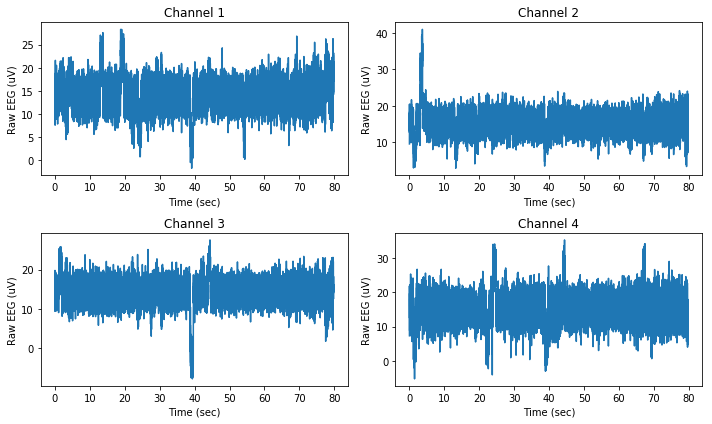

In [18]:
nchan = 4
ncol = 2; nrow = nchan / ncol
plt.figure(figsize=(ncol*5, nrow*3))
for Ichan in range(nchan):      
    plt.subplot(nrow,ncol,Ichan+1)
    plt.plot(t_sec,eeg_data_uV[:, Ichan])
    plt.xlabel("Time (sec)")       
    plt.ylabel("Raw EEG (uV)")
    plt.title("Channel " + str(Ichan+1))
    #plt.ylim([-1.5, 1.5])

    
plt.tight_layout()
plt.show()

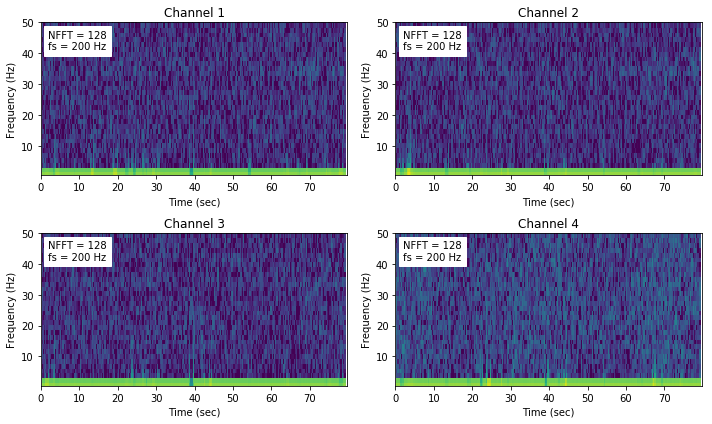

In [21]:
NFFT = 128  # pitck the length of the fft
FFTstep = NFFT/2  # do a new FFT every FFTstep data points
overlap = NFFT - FFTstep  # half-second steps
f_lim_Hz = [0.5, 50]   # frequency limits for plotting
ncol = 2
nchan = 4
nrow = nchan / ncol

plt.figure(figsize=(ncol*5, nrow*3))
for Ichan in range(nchan):      
    ax = plt.subplot(nrow,ncol,Ichan+1)
    data = np.array(eeg_data_uV[:,Ichan])
    spec_PSDperHz, freqs, t = mlab.specgram(data,
                               NFFT=NFFT,
                               window=mlab.window_hanning,
                               Fs=fs_Hz,
                               noverlap=overlap
                               ) # returns PSD power per Hz
    spec_PSDperBin = spec_PSDperHz * fs_Hz / float(NFFT)  #convert to "per bin"
    del spec_PSDperHz  # remove this variable so that I don't mistakenly use it

    plt.pcolor(t, freqs, 10*np.log10(spec_PSDperBin))  # dB re: 1 uV
    plt.clim(30+np.array([-50, 0]))
    plt.xlim(t_sec[0], t_sec[-1])
    plt.ylim([0, fs_Hz/2.0])  # show the full frequency content of the signal
    plt.ylim(f_lim_Hz)
    plt.xlabel('Time (sec)')
    plt.ylabel('Frequency (Hz)')
    plt.title("Channel " + str(Ichan+1))

    # add annotation for FFT Parameters
    ax.text(0.025, 0.95,
        "NFFT = " + str(NFFT) + "\nfs = " + str(int(fs_Hz)) + " Hz",
        transform=ax.transAxes,
        verticalalignment='top',
        horizontalalignment='left',
        backgroundcolor='w')

plt.tight_layout()
plt.show()

### alpha and beta bandwave decetion

In [22]:
bands = dict(alpha=[8, 12], beta=[13, 30])
n_cycles = 2
frequencies = np.arange(7, 30, 3)  # frequencies of interest
print(frequencies)

# inverse_operator = read_inverse_operator(data)

[ 7 10 13 16 19 22 25 28]


In [23]:
# stcs = source_band_induced_power(data, inverse_operator,bands, n_cycles=2,use_fft=False, n_jobs=1)
# power, phase_lock = induced_power(data, Fs=Fs, frequencies=frequencies, n_cycles=2, n_jobs=1)


In [24]:
fmin, fmax = 2, 300  # look at frequencies between 2 and 300Hz
n_fft = 2048  # the FFT size (n_fft). Ideally a power of 2


Extracting edf Parameters from /home/vagrant/notebooks/data/OpenBCI-RAW-2015-12-17_23-17-26_signals_only.edf...
Setting channel info structure...
Creating Raw.info structure...
Ready.
Adding average EEG reference projection.
1 projection items deactivated


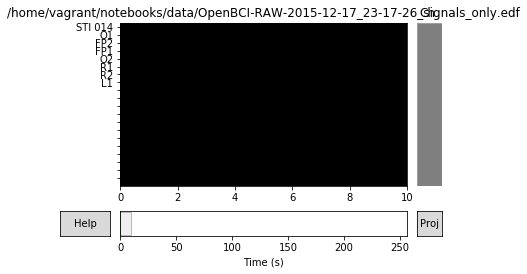

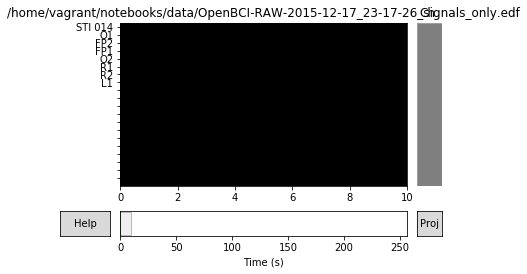

In [25]:
raw = mne.io.read_raw_edf(fnameEDF)
raw.set_eeg_reference()

raw.plot()


Effective window size : 10.240 (s)


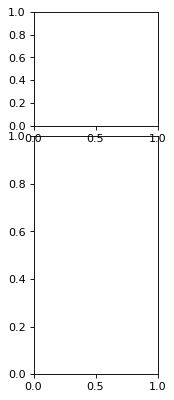

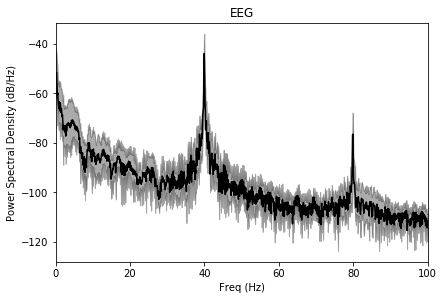

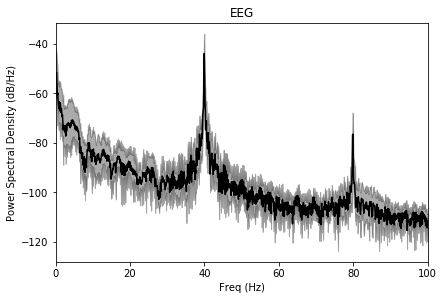

In [44]:
raw.plot_psd(tmax=np.inf)

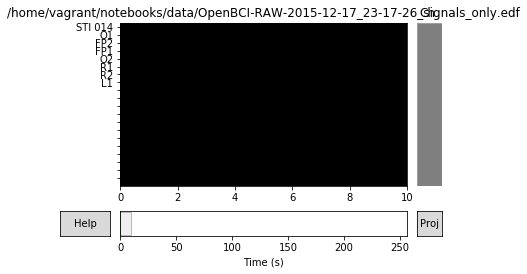

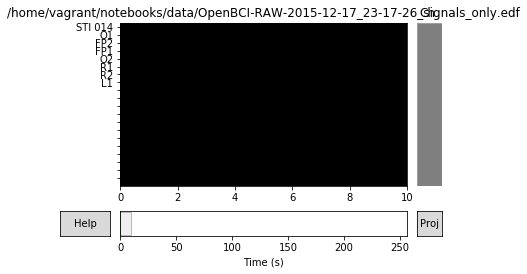

In [45]:
raw.plot()

Effective window size : 10.240 (s)


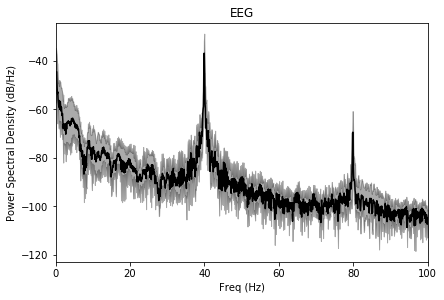

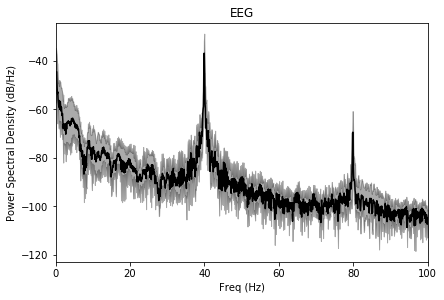

In [46]:
raw.plot_psd()


In [41]:
# events = mne.find_events(raw)
# inverse_operator = read_inverse_operator(raw)